In [7]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '800'
environ['batch_norm']= 'True'
environ['loss_func']='SMAPE'
environ['layers'] = '800 700 600 350 200 180'
environ['dropouts'] = '0.1 '* 6
environ['lr'] = '1e-03'
environ['log'] = 'False'
environ['weight_decay'] = '0.011'
environ['cuda_device'] ='cuda:5'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [8]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

function329_schedule_13
0
{'computations': {'computations_array': [{'comp_id': 1,
                                          'lhs_data_type': 'p_int32',
                                          'loop_iterators_ids': [2, 3],
                                          'operations_histogram': [[5, 3, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0,
                                                                    0,
                                                                    0,
                                                                    0]],
    

NameError: name 'exit' is not defined

In [3]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
elif loss_func == 'MAPE':
    criterion = mape_criterion
elif loss_func == 'SMAPE':
    criterion = smape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion])

if optimizer == 'SGD':
    l.opt_func = optim.SGD

In [4]:
l = l.load(f"r_speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [4]:
l.lr_find()
l.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [4]:
l.fit_one_cycle(int(environ['n_epochs']), float(environ['lr']))

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,104.661942,102.300491,287.807861,3.067903
2,95.419327,96.622795,343.448120,3.159903
3,93.724846,95.814415,358.764221,3.266283
4,92.683197,94.970634,364.280121,4.167940
5,79.877151,75.469284,394.043427,4.615024
6,72.907417,71.566765,378.542206,4.514072
7,69.528313,69.789955,373.386292,4.091285
8,67.515762,69.398399,227.227951,3.597232
9,66.386208,67.851303,332.230042,3.537573
10,65.443367,67.711411,187.448212,2.668400


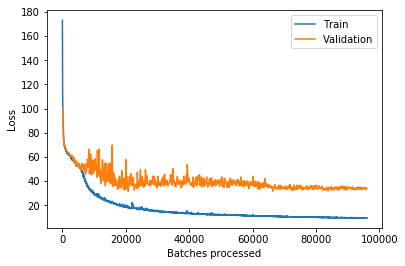

In [11]:
l.recorder.plot_losses()

In [6]:
l.save(f"r_speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [7]:
!ls models

old_models
old_repr
r_speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False2.pth
speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MSE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MSE_nlayers_5_log_True.pth
tmp.pth


In [12]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)

In [13]:
df = train_df

In [14]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,245283.000000,245283.000000,2.452830e+05,245283.000000
mean,1.102805,1.135724,2.135267e-01,22.577551
std,1.295271,1.405682,5.665563e-01,91.278419
min,0.010044,0.008491,2.048910e-07,0.000030
25%,0.280880,0.278690,5.817745e-03,1.646686
50%,0.855459,0.899071,3.095371e-02,5.807508
75%,1.050393,1.036481,1.352153e-01,17.479273
max,8.452207,16.089287,1.541526e+01,5824.463867


In [15]:
df = val_df

In [16]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.176222,1.430897,0.442006,42.532043
std,1.231279,1.683147,0.734061,148.393097
min,0.014810,0.014795,0.000040,0.006628
25%,0.389919,0.395193,0.024651,4.690779
50%,0.961758,1.000000,0.134899,22.480320
75%,1.257520,1.621683,0.497272,48.398965
max,7.889497,10.872228,6.232839,5399.246094


In [35]:
df[:][['index','name','prediction','target', 'abs_diff','APE']].to_csv(path_or_buf='./eval_results.csv',sep=';')

In [36]:
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)][['index','name','prediction','target', 'abs_diff','APE']].to_csv(path_or_buf='./eval_results.csv',sep=';')
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,2074.000000,2074.0,2074.000000,2074.000000
mean,0.998558,1.0,0.050076,5.007599
std,0.208153,0.0,0.202042,20.204212
min,0.603882,1.0,0.000066,0.006628
25%,0.979231,1.0,0.002551,0.255150
50%,0.995987,1.0,0.004715,0.471514
75%,0.997637,1.0,0.022805,2.280509
max,6.001675,1.0,5.001675,500.167511


In [19]:
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,725.000000,725.000000,725.000000,725.000000
mean,1.462764,1.519225,0.393448,29.481096
std,1.346193,1.422773,0.573493,31.370106
min,0.145803,0.091200,0.000040,0.009375
25%,0.494025,0.508859,0.070696,8.597638
50%,0.991690,0.993141,0.191803,19.992519
75%,2.151304,2.207209,0.496262,41.369717
max,7.768654,9.358214,3.835224,295.724640


In [21]:
df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,281.000000,281.000000,281.000000,281.000000
mean,4.372236,6.044158,1.848176,66.339111
std,2.171317,3.221366,1.231329,163.969162
min,0.904279,0.105179,0.001005,0.060693
25%,1.006489,2.546717,1.032713,18.170967
50%,5.899143,7.389543,1.563098,31.399256
75%,5.972240,8.668690,2.789691,43.133614
max,6.070222,10.872228,4.899988,848.387634


In [22]:
df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,232.000000,232.000000,232.000000,232.000000
mean,0.913173,0.918692,0.347373,122.910507
std,1.018806,1.168210,0.588294,610.275146
min,0.084280,0.018092,0.001015,0.220132
25%,0.260828,0.265846,0.033345,7.204351
50%,0.456005,0.466655,0.101908,19.017271
75%,1.092822,0.956079,0.327444,41.838287
max,5.042413,8.069739,3.409136,5399.246094


In [23]:
df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,868.000000,868.000000,868.000000,868.000000
mean,1.589693,1.748770,0.590289,37.538128
std,1.585954,1.605983,0.793788,50.443039
min,0.168853,0.057130,0.000085,0.043231
25%,0.442154,0.695116,0.105190,12.070397
50%,1.012416,1.241629,0.302328,29.301636
75%,2.136123,2.229650,0.773482,44.885977
max,7.889497,10.137201,4.684408,414.385712


In [24]:
df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,1276.000000,1276.000000,1276.000000,1276.000000
mean,1.962418,2.878316,1.036611,72.382378
std,1.334146,2.108479,1.021500,274.414642
min,0.101093,0.042484,0.000331,0.041299
25%,0.819918,0.977715,0.154067,10.751699
50%,2.072164,2.629361,0.717993,40.390493
75%,2.634203,4.365878,1.818399,50.273042
max,4.919624,9.784180,5.172597,2245.031982


In [25]:
df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,1663.000000,1663.000000,1663.000000,1663.000000
mean,0.827254,0.937209,0.295498,32.696384
std,0.851419,1.023356,0.457449,32.905022
min,0.014810,0.014836,0.000083,0.030472
25%,0.217906,0.246893,0.038760,9.840522
50%,0.529727,0.624512,0.132425,24.348541
75%,1.120389,1.173670,0.354944,48.979925
max,4.983345,8.724252,5.141850,309.855896


In [26]:
df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,2881.000000,2881.000000,2881.000000,2881.000000
mean,0.670118,0.858291,0.383388,57.996346
std,0.757664,1.094979,0.572025,79.790131
min,0.016312,0.014795,0.000374,0.131162
25%,0.158396,0.183774,0.059443,19.831461
50%,0.420433,0.424563,0.154730,43.728092
75%,0.847958,1.033311,0.456153,58.873505
max,4.961184,9.207530,6.232839,1148.485840


In [27]:
df[(df.interchange + df.tile + df.unroll != 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,7926.000000,7926.000000,7926.000000,7926.000000
mean,1.222709,1.543651,0.544563,52.351154
std,1.375149,1.874331,0.786424,164.959198
min,0.014810,0.014795,0.000040,0.009375
25%,0.304365,0.312547,0.065765,12.863225
50%,0.714742,0.830516,0.205677,34.351240
75%,1.788819,2.132191,0.660448,52.750795
max,7.889497,10.872228,6.232839,5399.246094


/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


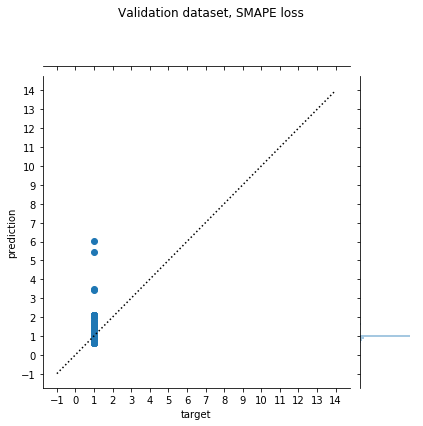

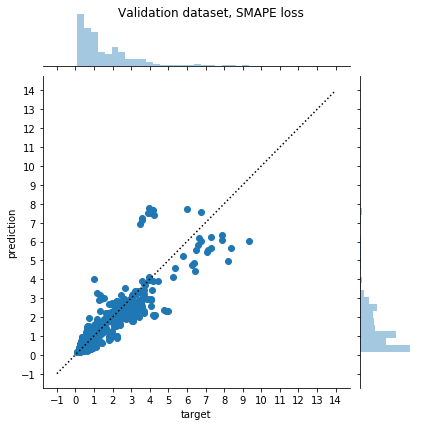

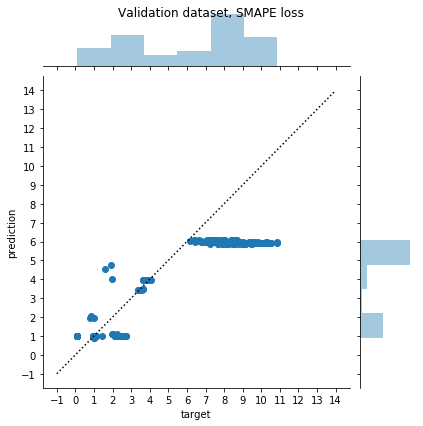

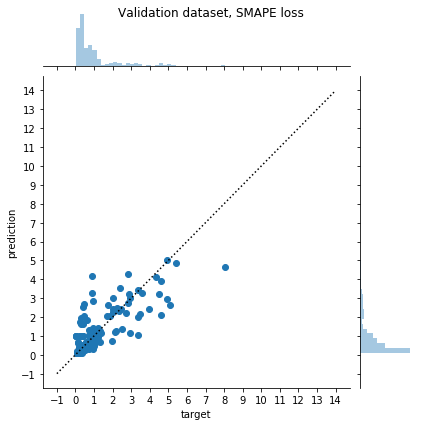

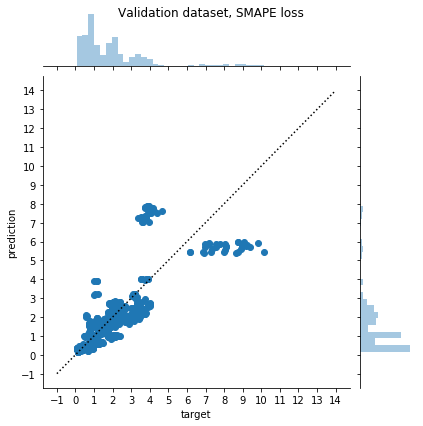

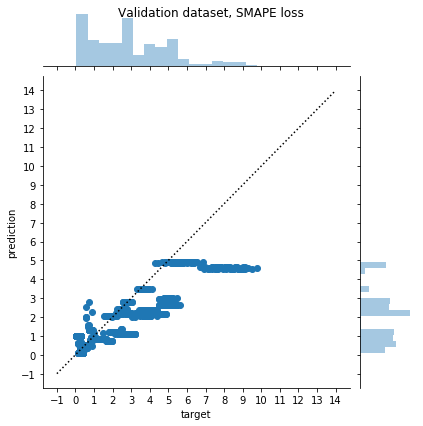

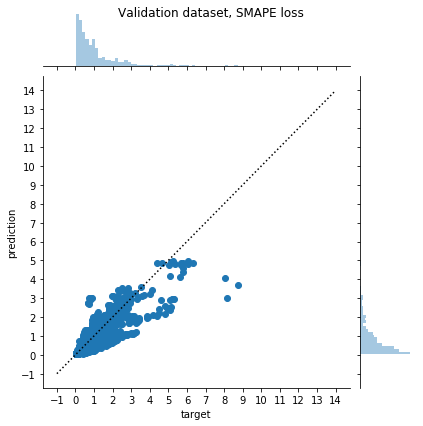

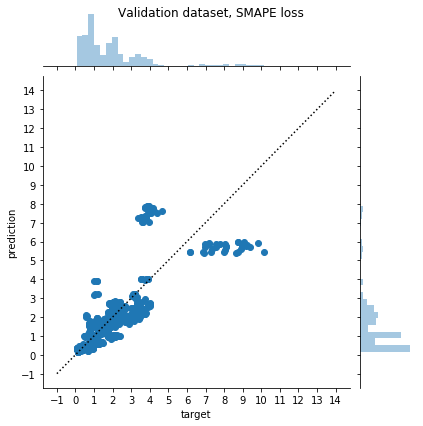

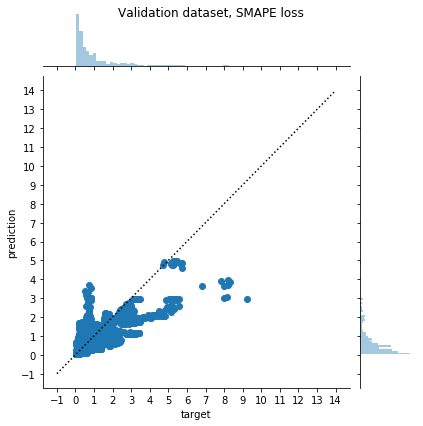

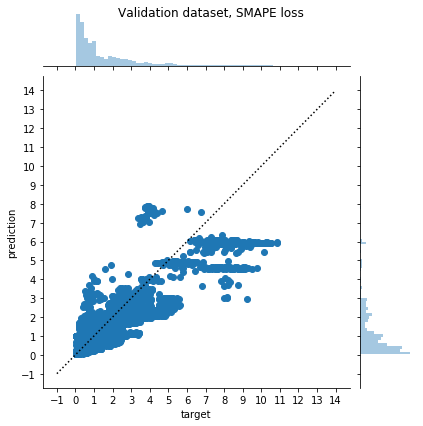

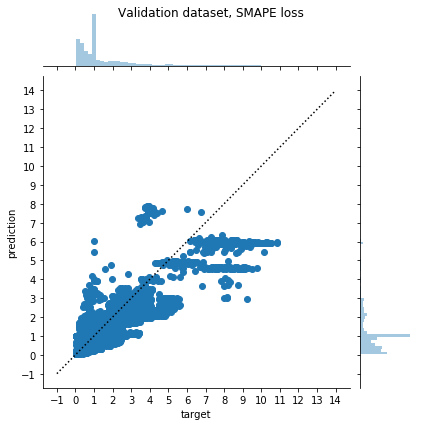

In [28]:
df1 = df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange + df.tile + df.unroll != 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")